In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("bmh")

import numpy as np
from scipy.stats import binom
from DP.utils import (
    binom_derivative,
    binom_optimal_privacy,
    fisher_gradient,
    fisher_information_privatized
)
from DP.linear_solver import LinearSolver
from DP.pga_with_edge_traversal import PGAWithEdgeTraversal
from matplotlib.patches import FancyArrowPatch

## Feasible set

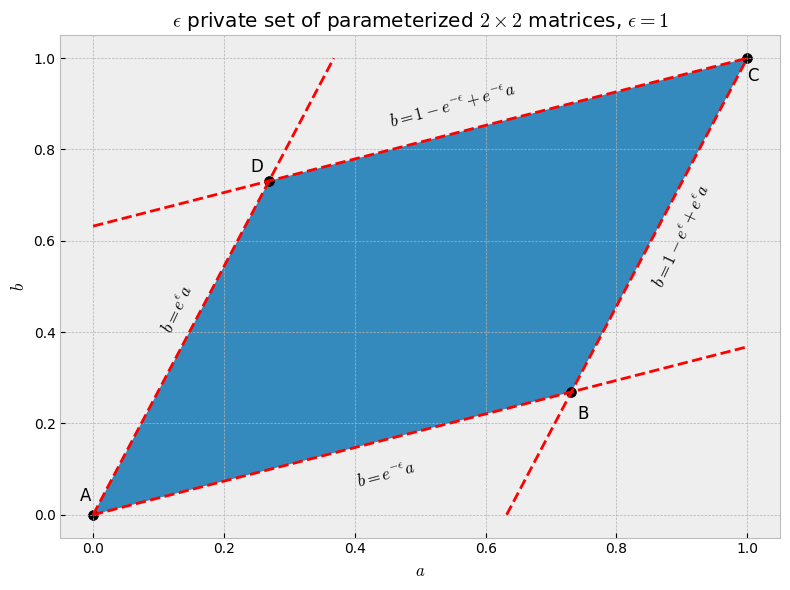

In [84]:
EPSILON = 1

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([0, np.exp(-EPSILON)], [0, 1], color="red", linestyle="dashed")
ax.plot([0, 1], [0, np.exp(-EPSILON)], color="red", linestyle="dashed")

ax.plot([0, 1], [1 - np.exp(-EPSILON), 1], color="red", linestyle="dashed")
ax.plot([1 - np.exp(-EPSILON), 1], [0, 1], color="red", linestyle="dashed")

ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1]
)

ax.scatter([0, (1-np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1, (1-np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON))],
           [0, (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON))],
           s=50, color="black")

ax.annotate(r"$b = e^\epsilon a$", xy=(0.10, 0.4), fontsize="large", rotation=65)
ax.annotate(r"$b = e^{-\epsilon} a$", xy=(0.4, 0.06), fontsize="large", rotation=15)
ax.annotate(r"$b = 1 - e^{-\epsilon} + e^{-\epsilon}a$", xy=(0.45, 0.85), fontsize="large", rotation=15)
ax.annotate(r"$b = 1 - e^\epsilon + e^\epsilon a$", xy=(0.85, 0.5), fontsize="large", rotation=65)

ax.annotate("A", xy=(-0.02, 0.03), fontsize="large")
ax.annotate("B", xy=(0.74, 0.21), fontsize="large")
ax.annotate("C", xy=(1, 0.95), fontsize="large")
ax.annotate("D", xy=(0.24, 0.75), fontsize="large")

ax.set_xlabel("$a$")
ax.set_ylabel("$b$")
ax.set_title(r"$\epsilon$ private set of parameterized $2\times 2$ matrices, $\epsilon=1$")

plt.tight_layout()
plt.savefig("figures/epsilon_private_set.png")
plt.show()

## Objective function with gradient

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:104: RuntimeWarning: invalid value encountered in divide
  2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:105: RuntimeWarning: invalid value encountered in divide
  - np.outer(p_theta, Q_ptheta_dot_squared) / Q_ptheta_squared
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:177: RuntimeWarning: invalid value encountered in divide
  return np.sum(numerator / denominator)


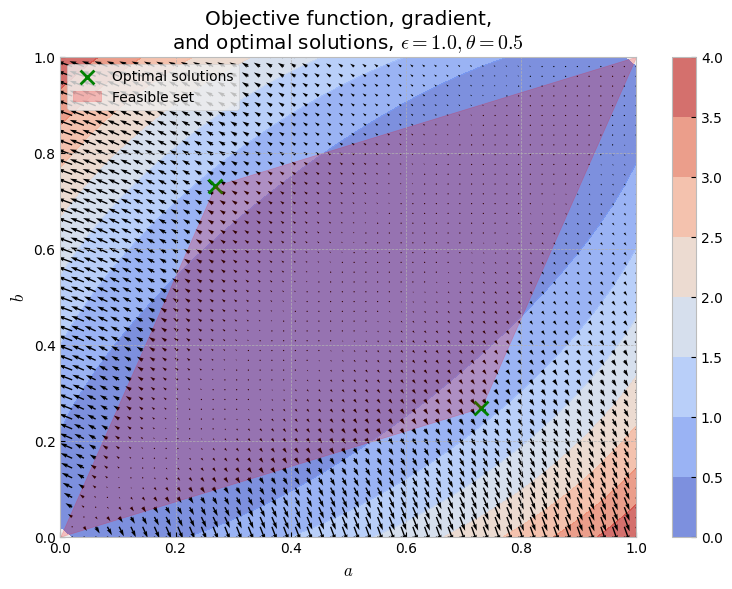

In [3]:
N = 1
THETA = 0.5
EPSILON = 1.0
NVALS = 50

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, N, THETA))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

# Feasible area plot
fig, ax = plt.subplots(figsize=(8, 6))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)

ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    label="Feasible set",
    color="red",
    alpha=0.2
)

plt.legend()
plt.title("Objective function, gradient,\n" + fr"and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.savefig("figures/objective_function_gradient.png")
plt.show()

## Everything PLUS gradient ascent path

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:104: RuntimeWarning: invalid value encountered in divide
  2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:105: RuntimeWarning: invalid value encountered in divide
  - np.outer(p_theta, Q_ptheta_dot_squared) / Q_ptheta_squared
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:177: RuntimeWarning: invalid value encountered in divide
  return np.sum(numerator / denominator)


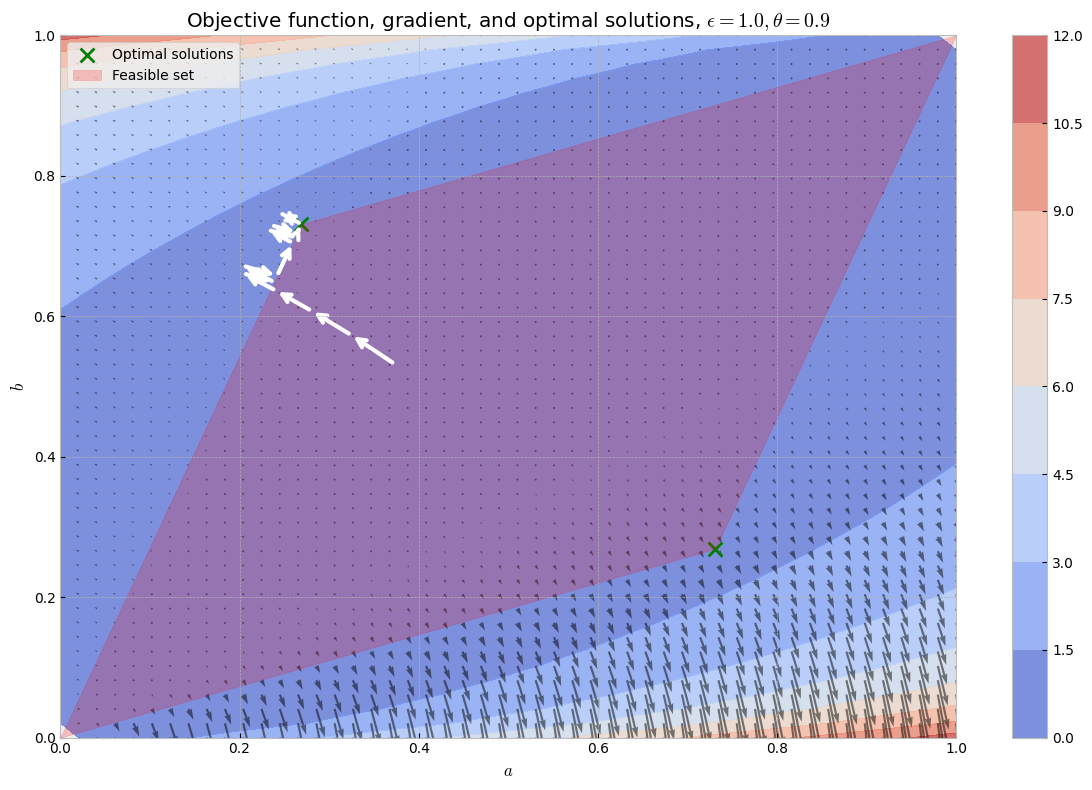

In [66]:
N = 1
THETA = 0.9
EPSILON = 1.0

p_theta = binom.pmf(np.arange(N + 1), N, THETA)
p_theta_dot = np.array([binom_derivative(i, N, THETA) for i in range(N + 1)])

a_vals = np.linspace(0, 1, NVALS)
b_vals = np.linspace(0, 1, NVALS)

grads_a = list()
grads_b = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, N, THETA))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

grads_a = np.array(grads_a).reshape((NVALS, NVALS), order="F")
grads_b = np.array(grads_b).reshape((NVALS, NVALS), order="F")
fishers = np.array(fishers).reshape((NVALS, NVALS), order="F")

opt_solutions, _, _ = binom_optimal_privacy(LinearSolver(), N, EPSILON, THETA)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

_, _, history = binom_optimal_privacy(PGAWithEdgeTraversal(), N, EPSILON, THETA)
all_history = np.array(history)

#colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, cmap="coolwarm", alpha=0.5)
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
ax.fill_between(
    x=[0, (1 - np.exp(-EPSILON)) / (np.exp(EPSILON) - np.exp(-EPSILON)), (1 - np.exp(EPSILON)) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1], 
    y1=[0, (np.exp(EPSILON) - 1) / (np.exp(EPSILON) - np.exp(-EPSILON)), 1 - np.exp(-EPSILON) + (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    y2=[0, (1 - np.exp(-EPSILON)) / (np.exp(2*EPSILON) - 1), (np.exp(-EPSILON) - 1) / (np.exp(-EPSILON) - np.exp(EPSILON)), 1],
    label="Feasible set",
    color="red",
    alpha=0.2
)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color="white", arrowstyle='->', mutation_scale=15, linewidth=3)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {EPSILON}, \theta = {THETA}$")
plt.tight_layout()
plt.savefig("figures/sample_ascent_path")
plt.show()